In [1]:
# spark libraries
import pyspark
from pyspark.sql.functions import max

# data wrangling
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('hard_drives_smart_5.csv').drop(columns='Unnamed: 0')

In [3]:
df.head()

,serial_number,model,capacity_bytes,max(failure),max(smart_9_raw),max(smart_5_raw),max(smart_187_raw),max(smart_188_raw),max(smart_197_raw),max(smart_198_raw)
0,PL1311LAG1SJAA,Hitachi HDS5C4040ALE630,4000787030016,0,43819.0,0.0,NaN,NaN,0.0,0.0
1,Z305KB36,ST4000DM000,4000787030016,0,31045.0,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi HDS5C3030ALA630,3000592982016,0,41668.0,0.0,NaN,NaN,0.0,0.0
3,ZA11NHSN,ST8000DM002,8001563222016,0,26284.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi HDS5C3030ALA630,3000592982016,0,47994.0,0.0,NaN,NaN,0.0,0.0


In [4]:
def prepare(df):
    
    # Convert capacity column from bytes to gigabytes
    df['capacity_bytes'] = round((df['capacity_bytes']/ 1_000_000_000),0)

    # Convert power hours to years
    df['max(smart_9_raw)'] = round((df['max(smart_9_raw)']/ 8760),1)

    # Create a new column for manufacturer
    df['manufacturer'] = df.model.apply(get_manufacturer)
    
    # Rename columns appropriately
    df = df.rename(columns={'capacity_bytes':'capacity_gigabytes',
                        'max(failure)':'failure',
                        'max(smart_9_raw)':'drive_age_in_years',
                        'max(smart_5_raw)':'reallocated_sectors_count',
                        'max(smart_187_raw)':'reported_uncorrectable_errors',
                        'max(smart_188_raw)':'command_timeout',
                        'max(smart_197_raw)':'current_pending_sector_count',
                        'max(smart_198_raw)':'uncorrectable_sector_count'})

    # Reorder columns 
    df = df[['serial_number','manufacturer','model','capacity_gigabytes',
          'failure','drive_age_in_years','reallocated_sectors_count',
         'reported_uncorrectable_errors','command_timeout',
          'current_pending_sector_count','uncorrectable_sector_count']]
    
    return df


def unique(df):
    '''
    Remove rows that duplicate serial numbers after aggregation.
    '''
    
    # remove rows with 0 copacity_gigabytes they were creating duplicate rows for some of the serial numbers
    df = df[df.capacity_gigabytes > 0]
    
    # remove rows by index that were creating duplicate serial numbers 
    df = df.drop([68273,50408,37150,154660,162948,50816,156370,31687,20823,75191,132189,4177,78104,103620,141505,95249,26969])
    
    return df

def get_manufacturer(model):
    if model.startswith('ST'):
        return 'Seagate'
    elif model.startswith('Sea'):
        return 'Seagate'
    elif model.startswith('HGST'):
        return 'Hitachi'
    elif model.startswith('Hit'):
        return 'Hitachi'
    elif model.startswith('TOS'):
        return 'Toshiba'
    elif model.startswith('DEL'):
        return 'Dell'
    elif model.startswith('WD'):
        return 'Western Digital'
    elif model.startswith('Sam'):
        return 'Samsung'
    elif model.startswith('SAM'):
        return 'Samsung'
    else:
        return 'Unknown'

def treat_nulls(df):
    # remove nulls from specific columns by imputing zeroes
    df.reported_uncorrectable_errors = df.reported_uncorrectable_errors.fillna(value=0)
    df.command_timeout = df.command_timeout.fillna(value=0)
    
    # treat remaining nulls by dropping specific rows
    df = df.dropna(axis=0)
    return df

In [5]:
df = prepare(df)

In [6]:
df = unique(df)

In [7]:
df = treat_nulls(df)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161830 entries, 0 to 169067
Data columns (total 11 columns):
serial_number                    161830 non-null object
manufacturer                     161830 non-null object
model                            161830 non-null object
capacity_gigabytes               161830 non-null float64
failure                          161830 non-null int64
drive_age_in_years               161830 non-null float64
reallocated_sectors_count        161830 non-null float64
reported_uncorrectable_errors    161830 non-null float64
command_timeout                  161830 non-null float64
current_pending_sector_count     161830 non-null float64
uncorrectable_sector_count       161830 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 14.8+ MB


In [9]:
import seaborn as sns 
import matplotlib.pyplot as plt

In [10]:
df_fails = df [df.failure == 1]
df_lives = df [df.failure == 0]

In [11]:
df_fails.drive_age_in_years.value_counts(bins=10, sort=False)

(-0.011300000000000001, 1.03]    1450
(1.03, 2.06]                     1840
(2.06, 3.09]                     1164
(3.09, 4.12]                     1095
(4.12, 5.15]                      280
(5.15, 6.18]                       65
(6.18, 7.21]                       11
(7.21, 8.24]                        1
(8.24, 9.27]                        1
(9.27, 10.3]                        4
Name: drive_age_in_years, dtype: int64

In [12]:
df_lives.drive_age_in_years.value_counts(bins=10, sort=False)

(-0.0092, 0.82]    24004
(0.82, 1.64]       15924
(1.64, 2.46]       30528
(2.46, 3.28]       20580
(3.28, 4.1]        29677
(4.1, 4.92]        24448
(4.92, 5.74]        9050
(5.74, 6.56]        1506
(6.56, 7.38]         161
(7.38, 8.2]           41
Name: drive_age_in_years, dtype: int64

In [13]:
df_fails.drive_age_in_years.agg(['mean','median'])

mean      2.064642
median    1.800000
Name: drive_age_in_years, dtype: float64

In [14]:
df_lives.drive_age_in_years.agg(['mean','median'])

mean      2.747618
median    2.700000
Name: drive_age_in_years, dtype: float64

In [15]:
df_fails.describe()

,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
count,5911.000000,5911.0,5911.000000,5911.000000,5911.000000,5.911000e+03,5911.000000,5911.000000
mean,5796.514803,1.0,2.064642,1440.317205,75.532905,2.118090e+09,164.342582,155.387075
std,3519.640805,0.0,1.311870,6376.777343,1973.510975,1.164497e+11,2359.707545,2336.187420
min,80.000000,1.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,4001.000000,1.0,1.100000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,4001.000000,1.0,1.800000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,8002.000000,1.0,3.000000,16.000000,3.000000,0.000000e+00,24.000000,16.000000
max,14001.000000,1.0,10.300000,65392.000000,65535.000000,8.933668e+12,142616.000000,142616.000000


In [16]:
df_lives.describe()

,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
count,155919.000000,155919.0,155919.000000,155919.000000,155919.000000,1.559190e+05,155919.000000,155919.000000
mean,7185.167061,0.0,2.747618,17.904720,1.143299,1.378444e+08,0.273533,0.247019
std,3793.669950,0.0,1.526695,632.245333,219.129699,9.649409e+09,12.603720,12.470573
min,80.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,4001.000000,0.0,1.600000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,6001.000000,0.0,2.700000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,12000.000000,0.0,4.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
max,14001.000000,0.0,8.200000,65312.000000,65535.000000,3.564877e+12,3568.000000,3568.000000


In [427]:
# for col in df_fails.columns[6:]:
#     sns.scatterplot(data=df, y=df[col], x=df.drive_age_in_years)
#     plt.title(col)
#     plt.show()

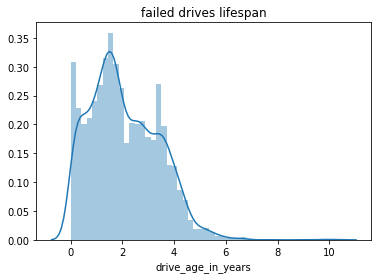

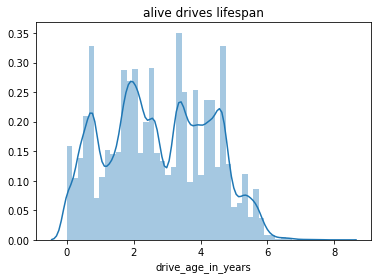

In [17]:
# plt.figure(figsize=(12,8))
sns.distplot(df_fails.drive_age_in_years)
plt.title('failed drives lifespan')
plt.show()

sns.distplot(df_lives.drive_age_in_years)
plt.title('alive drives lifespan')
plt.show()

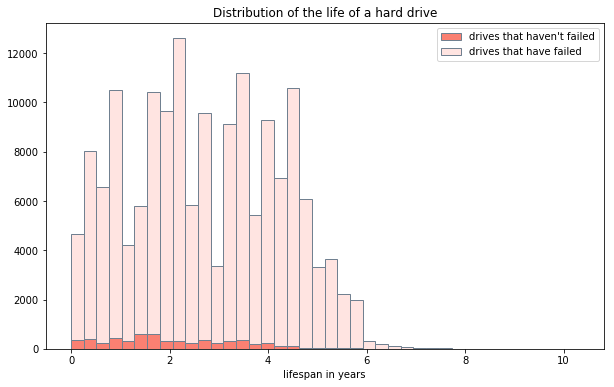

In [18]:
plt.figure(figsize=(10,6))
plt.hist([df_fails.drive_age_in_years, df_lives.drive_age_in_years], 
         stacked=True, bins=40, edgecolor='slategrey', color=['salmon','mistyrose'])
plt.legend(["drives that haven't failed","drives that have failed"])
plt.title("Distribution of the life of a hard drive")
plt.xlabel("lifespan in years")
# plt.yticks([])
plt.show()

In [19]:
def make_binary_values(df):
    df.reallocated_sectors_count = np.where(df.reallocated_sectors_count > 0, '1','0').astype(bool)
    df.reported_uncorrectable_errors = np.where(df.reported_uncorrectable_errors > 0, '1', '0').astype(bool)
    df.command_timeout = np.where(df.command_timeout > 0, '1', '0').astype(bool)
    df.current_pending_sector_count = np.where(df.current_pending_sector_count > 0, '1', '0').astype(bool)
    df.uncorrectable_sector_count = np.where(df.uncorrectable_sector_count > 0, '1', '0').astype(bool)
    return df

In [20]:
df = make_binary_values(df)

In [21]:
df.head()

,serial_number,manufacturer,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
0,PL1311LAG1SJAA,Hitachi,Hitachi HDS5C4040ALE630,4001.0,0,5.0,False,False,False,False,False
1,Z305KB36,Seagate,ST4000DM000,4001.0,0,3.5,False,False,False,False,False
2,MJ0351YNG9MZXA,Hitachi,Hitachi HDS5C3030ALA630,3001.0,0,4.8,False,False,False,False,False
3,ZA11NHSN,Seagate,ST8000DM002,8002.0,0,3.0,False,False,False,False,False
4,MJ1311YNG2ZSEA,Hitachi,Hitachi HDS5C3030ALA630,3001.0,0,5.5,False,False,False,False,False


In [22]:
df.groupby('failure').sum().iloc[:,3:]

,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
failure,,,,
0,1679.0,3813.0,1742.0,1440.0
1,2079.0,559.0,2489.0,2190.0


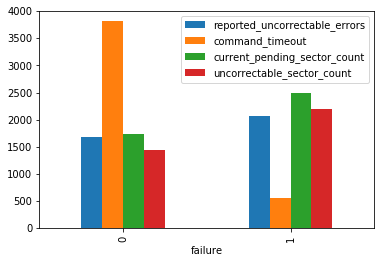

In [23]:
df.groupby('failure').sum().iloc[:,3:].plot.bar()
plt.show()

In [25]:
def remove_manufacturers(df):
    
    # Remove manufactures with low value counts
    df = df[(df.manufacturer != 'Samsung') & (df.manufacturer != 'Unknown')]
    return df


def early_failure(df,cut_off=1.6):
    '''
    Add column to identify early failures based on the age of the hard drive 

    '''
    df['early_failure'] = np.where((df.drive_age_in_years <= cut_off) & (df.failure == 1), 1, 0)
    # df['early_failure']= 1
    # df['early_failure'][df.drive_age_in_years<=cut_off] = 1
    # df['early_failure'][df.drive_age_in_years>cut_off] = 0
    
    return df

def old_or_fail(df,cut_off=1.6):
    '''
    Retain rows for drives that have failed or are older than the cut off age
    '''

    df = df[(df.failure==1)|(df.drive_age_in_years > cut_off)]

    return df


def get_quartile(df,Q1=1.6,Q2=2.6,Q3=4):
    '''
    Add colulmn to identify which quartile drive falls in based on the age of the hard drive
    '''
    
    df['quartile']= 1
    df['quartile'][df.drive_age_in_years<Q1] = 'Q1'
    df['quartile'][(df.drive_age_in_years>=Q1) & (df.drive_age_in_years<Q2)] = 'Q2'
    df['quartile'][(df.drive_age_in_years>=Q2) & (df.drive_age_in_years<Q3)] = 'Q3'
    df['quartile'][(df.drive_age_in_years>=Q3)] = 'Q4'
    
    return df

In [26]:
# import warnings
# warnings.filterwarnings("ignore")

df = early_failure(df)

In [27]:
df = old_or_fail(df)

In [28]:
df = remove_manufacturers(df)

In [29]:
# df = get_quartile(df)

In [30]:
df

,serial_number,manufacturer,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count,early_failure
0,PL1311LAG1SJAA,Hitachi,Hitachi HDS5C4040ALE630,4001.0,0,5.0,False,False,False,False,False,0
1,Z305KB36,Seagate,ST4000DM000,4001.0,0,3.5,False,False,False,False,False,0
2,MJ0351YNG9MZXA,Hitachi,Hitachi HDS5C3030ALA630,3001.0,0,4.8,False,False,False,False,False,0
3,ZA11NHSN,Seagate,ST8000DM002,8002.0,0,3.0,False,False,False,False,False,0
4,MJ1311YNG2ZSEA,Hitachi,Hitachi HDS5C3030ALA630,3001.0,0,5.5,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...
168877,ZJV00B8Z,Seagate,ST12000NM0007,12000.0,0,1.7,False,False,False,False,False,0
168884,ZJV03NK5,Seagate,ST12000NM0007,12000.0,1,1.2,True,True,False,False,False,1
168940,ZJV1K5HB,Seagate,ST12000NM0007,12000.0,1,0.8,True,True,True,False,False,1
168952,ZCH065XF,Seagate,ST12000NM0007,12000.0,1,0.6,True,False,True,False,False,1


In [31]:
from sklearn.model_selection import train_test_split

def split_my_data(df):
    # define target and features
    X = df.drop(columns = ['early_failure', 'failure', 'drive_age_in_years'])
    y = df[['early_failure']]

    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .80, random_state = 123, stratify=df.early_failure)
    return X_train, X_test, y_train, y_test

In [32]:
X_train, X_test, y_train, y_test = split_my_data(df)

In [33]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((97520, 9), (97520, 1), (24380, 9), (24380, 1))

In [34]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def encode_hot(train, test, col_name):
    encoded_values = sorted(list(train[col_name].unique()))

    # Integer Encoding
    int_encoder = LabelEncoder()
    train.encoded = int_encoder.fit_transform(train[col_name])
    test.encoded = int_encoder.transform(test[col_name])

    # create 2D np arrays of the encoded variable (in train and test)
    train_array = np.array(train.encoded).reshape(len(train.encoded),1)
    test_array = np.array(test.encoded).reshape(len(test.encoded),1)

    # One Hot Encoding
    ohe = OneHotEncoder(sparse=False, categories='auto')
    train_ohe = ohe.fit_transform(train_array)
    test_ohe = ohe.transform(test_array)

    # Turn the array of new values into a data frame with columns names being the values
    # and index matching that of train/test
    # then merge the new dataframe with the existing train/test dataframe
    # and drop original column
    train_encoded = pd.DataFrame(data=train_ohe, columns=encoded_values, index=train.index)
    train = train.join(train_encoded)
    train = train.drop(columns = col_name)

    test_encoded = pd.DataFrame(data=test_ohe, columns=encoded_values, index=test.index)
    test = test.join(test_encoded)
    test = test.drop(columns = col_name)

    return train, test

In [35]:
X_train, X_test = encode_hot(X_train, X_test, 'manufacturer')

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


In [36]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97520 entries, 116194 to 77819
Data columns (total 12 columns):
serial_number                    97520 non-null object
model                            97520 non-null object
capacity_gigabytes               97520 non-null float64
reallocated_sectors_count        97520 non-null bool
reported_uncorrectable_errors    97520 non-null bool
command_timeout                  97520 non-null bool
current_pending_sector_count     97520 non-null bool
uncorrectable_sector_count       97520 non-null bool
Hitachi                          97520 non-null float64
Seagate                          97520 non-null float64
Toshiba                          97520 non-null float64
Western Digital                  97520 non-null float64
dtypes: bool(5), float64(5), object(2)
memory usage: 8.9+ MB


In [53]:
y_train = y_train.early_failure

In [45]:
# X_train.drop('model',axis=1,inplace=True)
# X_train.drop('serial_number',axis=1,inplace=True)

In [46]:
X_train.columns

Index(['capacity_gigabytes', 'reallocated_sectors_count',
       'reported_uncorrectable_errors', 'command_timeout',
       'current_pending_sector_count', 'uncorrectable_sector_count', 'Hitachi',
       'Seagate', 'Toshiba', 'Western Digital'],
      dtype='object')

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [48]:
def logit_model(X_train, y_train):
    logit = LogisticRegression(solver = 'liblinear', random_state = 123)
    logit.fit(X_train, y_train)
    
    y_pred = logit.predict(X_train)
    y_pred_proba = logit.predict_proba(X_train)

    print(pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(logit.coef_))], axis = 1))
    print()
    print(y_pred_proba)
    print()
    print(confusion_matrix(y_train, y_pred))
    print()    
    print(classification_report(y_train, y_pred))

In [54]:
logit_model(X_train, y_train)

                               0         0
0             capacity_gigabytes  0.000178
1      reallocated_sectors_count  1.475272
2  reported_uncorrectable_errors  1.344049
3                command_timeout  1.173907
4   current_pending_sector_count  1.664929
5     uncorrectable_sector_count  0.139741
6                        Hitachi -2.103114
7                        Seagate -1.843683
8                        Toshiba  0.808487
9                Western Digital -0.704695

[[0.98611427 0.01388573]
 [0.99313752 0.00686248]
 [0.97211962 0.02788038]
 ...
 [0.99313752 0.00686248]
 [0.99469735 0.00530265]
 [0.99469735 0.00530265]]

[[95217   225]
 [ 1861   217]]

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     95442
           1       0.49      0.10      0.17      2078

    accuracy                           0.98     97520
   macro avg       0.74      0.55      0.58     97520
weighted avg       0.97      0.98      0.97     97520



In [1]:
from sklearn.model_selection import GridSearchCV

def grid_logit_model(X_train, y_train):
    grid_values = {'C':[0.001,.009,0.01,.09,1,5,10,25]}

    logit = LogisticRegression(solver = 'liblinear', class_weight='balanced', random_state = 123)

    grid = GridSearchCV(logit, grid_values, cv=3, scoring='recall')
    grid.fit(X_train, y_train)    
    
    results = grid.cv_results_
    test_scores = results['mean_test_score']
    params = results['params']
    
    print()
    print(confusion_matrix(y_train, y_pred))
    print()    
    print(classification_report(y_train, y_pred))    
    
#     return pd.DataFrame(params).sort_values(by='score')

In [2]:
grid_logit_model(X_train, y_train)

NameError: name 'X_train' is not defined

In [4]:
import pandas as pd 
import numpy as np 

import pyspark
from pyspark.sql.functions import max

import os 

# create local spark enviroment
spark = pyspark.sql.SparkSession.builder.getOrCreate()

def combine_data():
    # pull 2016, 2017, 2019 data
    df_2016 = spark.read.csv('../data/data_Q*_2016/*.csv', header=True, inferSchema=True)
    df_2017 = spark.read.csv('../data/data_Q*_2017/*.csv', header=True, inferSchema=True)
    df_2019 = spark.read.csv('../data/data_Q*_2019/*.csv', header=True, inferSchema=True)

    # pull 2018 data by quarter, as they have different columns
    df_2018_1 = spark.read.csv('../data/data_Q1_2018/*.csv', header=True, inferSchema=True)
    df_2018_2 = spark.read.csv('../data/data_Q2_2018/*.csv', header=True, inferSchema=True)
    df_2018_3 = spark.read.csv('../data/data_Q3_2018/*.csv', header=True, inferSchema=True)
    df_2018_4 = spark.read.csv('../data/data_Q4_2018/*.csv', header=True, inferSchema=True)

    # find stats that aren't included in older years
    cols_2016 = df_2016.columns
    cols_2019 = df_2019.columns
    remove_traits_list = list(set(cols_2019).difference(cols_2016))

    # remove the established stats
    for trait in remove_traits_list:
        df_2018_1 = df_2018_1.drop(trait)
        df_2018_2 = df_2018_2.drop(trait)
        df_2018_3 = df_2018_3.drop(trait)
        df_2018_4 = df_2018_4.drop(trait)
        df_2019 = df_2019.drop(trait)

    # combine all dfs together
    df = df_2016.union(df_2017).union(df_2018_1).union(df_2018_2).union(df_2018_3).union(df_2018_4).union(df_2019)
    return df

In [5]:
def extract_smart_5(df):
    df = df.groupby('serial_number', 'model', 'capacity_bytes'
                   ).agg(max('failure'), max('smart_9_raw'), max('smart_5_raw'), max('smart_187_raw'), 
                        max('smart_188_raw') , max('smart_197_raw'), max('smart_198_raw')
                        )
    return df

In [7]:
df = combine_data()

In [10]:
df.show(vertical=True)

-RECORD 0------------------------------------
 date                 | 2016-12-13 00:00:00  
 serial_number        | MJ0351YNG9Z0XA       
 model                | Hitachi HDS5C3030... 
 capacity_bytes       | 3000592982016        
 failure              | 0                    
 smart_1_normalized   | 100                  
 smart_1_raw          | 0                    
 smart_2_normalized   | 135                  
 smart_2_raw          | 108                  
 smart_3_normalized   | 127                  
 smart_3_raw          | 554                  
 smart_4_normalized   | 100                  
 smart_4_raw          | 15                   
 smart_5_normalized   | 100                  
 smart_5_raw          | 0                    
 smart_7_normalized   | 100                  
 smart_7_raw          | 0                    
 smart_8_normalized   | 122                  
 smart_8_raw          | 37                   
 smart_9_normalized   | 95                   
 smart_9_raw          | 36257     

In [13]:
df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- serial_number: string (nullable = true)
 |-- model: string (nullable = true)
 |-- capacity_bytes: long (nullable = true)
 |-- failure: integer (nullable = true)
 |-- smart_1_normalized: integer (nullable = true)
 |-- smart_1_raw: long (nullable = true)
 |-- smart_2_normalized: integer (nullable = true)
 |-- smart_2_raw: integer (nullable = true)
 |-- smart_3_normalized: integer (nullable = true)
 |-- smart_3_raw: integer (nullable = true)
 |-- smart_4_normalized: integer (nullable = true)
 |-- smart_4_raw: integer (nullable = true)
 |-- smart_5_normalized: integer (nullable = true)
 |-- smart_5_raw: integer (nullable = true)
 |-- smart_7_normalized: integer (nullable = true)
 |-- smart_7_raw: long (nullable = true)
 |-- smart_8_normalized: integer (nullable = true)
 |-- smart_8_raw: integer (nullable = true)
 |-- smart_9_normalized: integer (nullable = true)
 |-- smart_9_raw: integer (nullable = true)
 |-- smart_10_normalized: integer (n

In [23]:
df_agg = df.groupby('serial_number', 'model', 'capacity_bytes').max()

In [26]:
df_agg

DataFrame[serial_number: string, model: string, capacity_bytes: bigint, max(capacity_bytes): bigint, max(failure): int, max(smart_1_normalized): int, max(smart_1_raw): bigint, max(smart_2_normalized): int, max(smart_2_raw): int, max(smart_3_normalized): int, max(smart_3_raw): int, max(smart_4_normalized): int, max(smart_4_raw): int, max(smart_5_normalized): int, max(smart_5_raw): int, max(smart_7_normalized): int, max(smart_7_raw): bigint, max(smart_8_normalized): int, max(smart_8_raw): int, max(smart_9_normalized): int, max(smart_9_raw): int, max(smart_10_normalized): int, max(smart_10_raw): int, max(smart_11_normalized): int, max(smart_11_raw): int, max(smart_12_normalized): int, max(smart_12_raw): int, max(smart_22_normalized): int, max(smart_22_raw): int, max(smart_183_normalized): int, max(smart_183_raw): int, max(smart_184_normalized): int, max(smart_184_raw): int, max(smart_187_normalized): int, max(smart_187_raw): int, max(smart_188_normalized): int, max(smart_188_raw): bigint,

In [28]:
df1 = df_agg.select("*").toPandas()

In [31]:
df1.to_csv("hard_drives_smart_all.csv")

In [30]:
df1

,serial_number,model,capacity_bytes,max(capacity_bytes),max(failure),max(smart_1_normalized),max(smart_1_raw),max(smart_2_normalized),max(smart_2_raw),max(smart_3_normalized),...,max(smart_242_normalized),max(smart_242_raw),max(smart_250_normalized),max(smart_250_raw),max(smart_251_normalized),max(smart_251_raw),max(smart_252_normalized),max(smart_252_raw),max(smart_254_normalized),max(smart_254_raw)
0,PL1311LAG1SJAA,Hitachi HDS5C4040ALE630,4000787030016,4000787030016,0,100.0,1.0,135.0,99.0,123.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Z305KB36,ST4000DM000,4000787030016,4000787030016,0,120.0,243787512.0,NaN,NaN,91.0,...,100.0,1.522021e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MJ0351YNG9MZXA,Hitachi HDS5C3030ALA630,3000592982016,3000592982016,0,100.0,1.0,134.0,112.0,127.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ZA11NHSN,ST8000DM002,8001563222016,8001563222016,0,100.0,244007456.0,NaN,NaN,98.0,...,100.0,1.466534e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MJ1311YNG2ZSEA,Hitachi HDS5C3030ALA630,3000592982016,3000592982016,0,100.0,1245191.0,100.0,0.0,125.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169068,ZCH07T8J,ST12000NM0007,-1,-1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169069,PL1331LAHDXS7H,HGST HMS5C4040BLE640,-1,-1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169070,ZCH0CCWS,ST12000NM0007,-1,-1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169071,ZJV2TH56,ST12000NM0007,-1,-1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
